✅ Dataset Loaded. Shape: (11229, 16)
📌 Available Columns: ['datetime', 'longitude', 'latitude', 'uhi_index', 'land_surface_temp', 'band1', 'band2', 'band3', 'band4', 'air_temp_at_surface_', 'relative_humidity_', 'avg_wind_speed_', 'wind_direction_', 'solar_flux_', 'nearest_building_lon', 'nearest_building_lat']
✅ Removed Prohibited Features.
✅ Extracted Temporal Features: 'hour_sin', 'hour_cos', 'weekday', 'month', 'is_weekend'
✅ Engineered Advanced Features.
✅ Computed NDVI, NDBI, and EVI.
✅ Missing Values Handled Using KNN Imputation.
✅ Scaled Features using QuantileTransformer.
✅ Selected Top Features: ['nearest_building_lon', 'nearest_building_lat', 'band1', 'wind_temp_interaction', 'wind_chill', 'humidity_wind_interaction', 'solar_flux_', 'solar_temp_interaction', 'wind_direction_', 'heat_index', 'humidity_temp_interaction', 'relative_humidity_', 'avg_wind_speed_', 'air_temp_at_surface_', 'temp_gradient', 'land_surface_temp', 'band3', 'band2', 'ndbi', 'band4', 'evi', 'ndvi', 'is_w

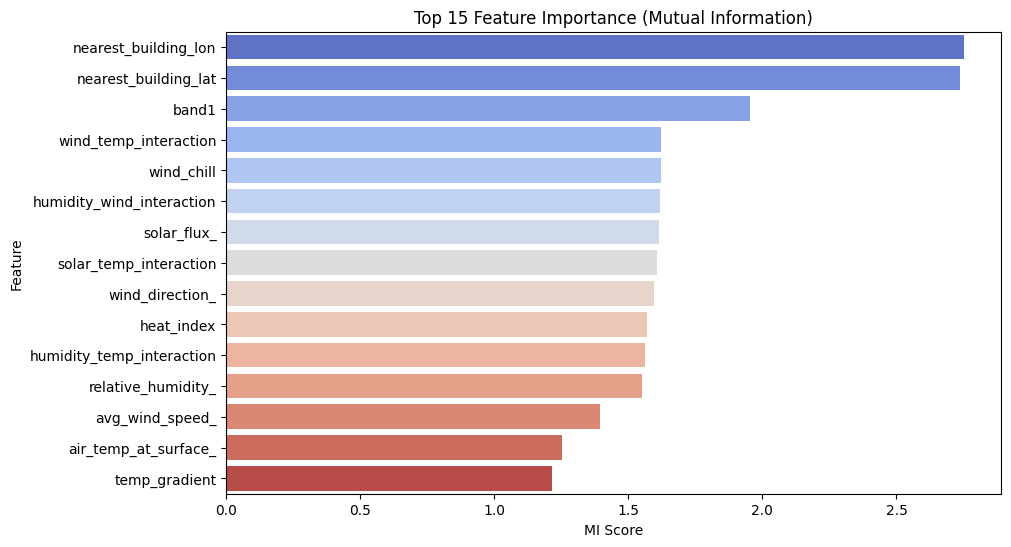

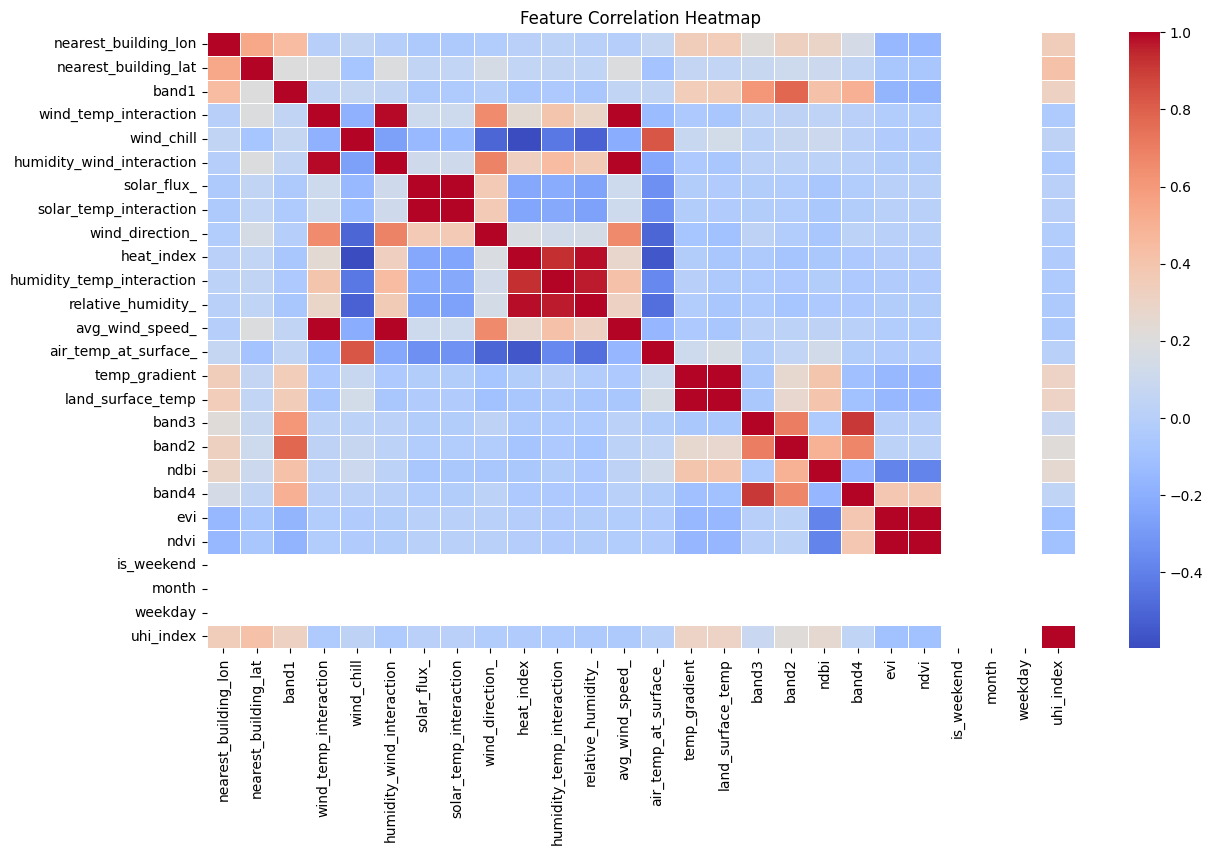

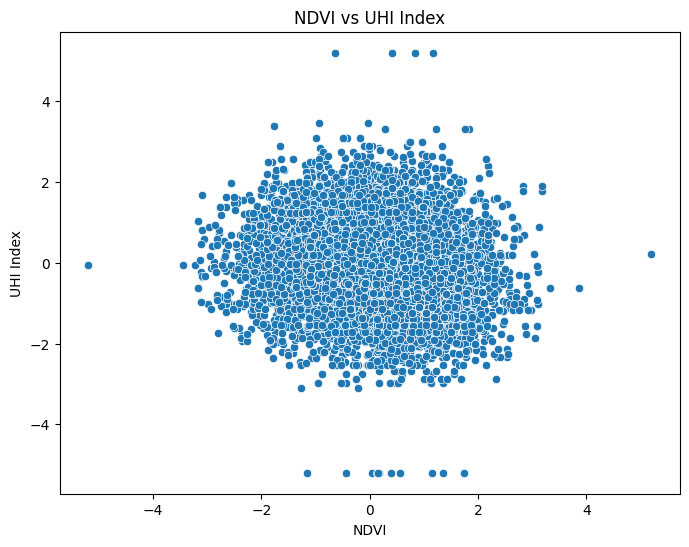

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
from sklearn.preprocessing import RobustScaler, QuantileTransformer, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression

# ----------------- 1️⃣ Load Data -----------------
data_path = "../data/processed/UHI_Weather_Building_Sentinel_LST_Merged.csv"
df = pd.read_csv(data_path)
print(f"✅ Dataset Loaded. Shape: {df.shape}")

# ✅ Standardize Column Names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
print("📌 Available Columns:", df.columns.tolist())

# ----------------- 2️⃣ Remove Prohibited Features -----------------
prohibited_cols = ["longitude", "latitude", "building_distance_m"]
df.drop(columns=[col for col in prohibited_cols if col in df.columns], errors="ignore", inplace=True)
print("✅ Removed Prohibited Features.")

# ----------------- 3️⃣ Temporal Feature Engineering -----------------
if "datetime" in df.columns:
    df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")

    # ✅ Cyclic Encoding for Hour
    df["hour"] = df["datetime"].dt.hour
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

    # ✅ Additional Temporal Features
    df["weekday"] = df["datetime"].dt.weekday
    df["month"] = df["datetime"].dt.month
    df["is_weekend"] = (df["weekday"] >= 5).astype(int)

    print("✅ Extracted Temporal Features: 'hour_sin', 'hour_cos', 'weekday', 'month', 'is_weekend'")
    df.drop(columns=["datetime", "hour"], inplace=True)
else:
    print("❌ 'datetime' column missing; skipping temporal features.")

# ----------------- 4️⃣ Advanced Feature Engineering -----------------
df["temp_gradient"] = df["land_surface_temp"] - df["air_temp_at_surface_"]
df["humidity_temp_interaction"] = df["relative_humidity_"] * df["air_temp_at_surface_"]
df["wind_temp_interaction"] = df["avg_wind_speed_"] * df["air_temp_at_surface_"]
df["solar_temp_interaction"] = df["solar_flux_"] * df["air_temp_at_surface_"]
df["humidity_wind_interaction"] = df["relative_humidity_"] * df["avg_wind_speed_"]

df["wind_chill"] = 13.12 + 0.6215 * df["air_temp_at_surface_"] - 11.37 * df["avg_wind_speed_"] ** 0.16 + 0.3965 * df["air_temp_at_surface_"] * df["avg_wind_speed_"] ** 0.16
df["heat_index"] = -42.379 + 2.049 * df["air_temp_at_surface_"] + 10.143 * df["relative_humidity_"] - 0.224 * df["air_temp_at_surface_"] * df["relative_humidity_"]
print("✅ Engineered Advanced Features.")

# ----------------- 5️⃣ Satellite Feature Engineering -----------------
df["ndvi"] = (df["band4"] - df["band3"]) / (df["band4"] + df["band3"] + 1e-6)
df["ndbi"] = (df["band2"] - df["band4"]) / (df["band2"] + df["band4"] + 1e-6)
df["evi"] = 2.5 * (df["band4"] - df["band3"]) / (df["band4"] + (6 * df["band3"]) - (7.5 * df["relative_humidity_"]) + 1)
print("✅ Computed NDVI, NDBI, and EVI.")

# ----------------- 6️⃣ Handle Missing Values Using KNN Imputation -----------------
imputer = KNNImputer(n_neighbors=5)
df.iloc[:, :] = imputer.fit_transform(df)
print("✅ Missing Values Handled Using KNN Imputation.")

# ----------------- 7️⃣ Feature Scaling Using Quantile Transformer -----------------
scaler = QuantileTransformer(output_distribution="normal")
df[df.columns] = scaler.fit_transform(df)
print("✅ Scaled Features using QuantileTransformer.")

# ----------------- 8️⃣ Feature Selection Using Mutual Information -----------------
X = df.drop(columns=["uhi_index"])
y = df["uhi_index"]
mi_scores = mutual_info_regression(X, y)
mi_scores_df = pd.DataFrame({"Feature": X.columns, "MI Score": mi_scores})
mi_scores_df.sort_values(by="MI Score", ascending=False, inplace=True)
top_features = mi_scores_df["Feature"].head(25).tolist()
df = df[top_features + ["uhi_index"]]
print(f"✅ Selected Top Features: {top_features}")

# ----------------- 9️⃣ Save Processed Dataset -----------------
feature_engineered_path = "../data/processed/UHI_Weather_Building_Sentinel_LST_Featured_Cleaned.csv"
df.to_csv(feature_engineered_path, index=False)
print(f"✅ Feature Engineered Dataset Saved: {feature_engineered_path}")

# ----------------- 🔟 Visualizations -----------------
plt.figure(figsize=(10, 6))
sns.barplot(data=mi_scores_df.head(15), x="MI Score", y="Feature", palette="coolwarm")
plt.title("Top 15 Feature Importance (Mutual Information)")
plt.show()

plt.figure(figsize=(14, 8))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["ndvi"], y=df["uhi_index"])
plt.title("NDVI vs UHI Index")
plt.xlabel("NDVI")
plt.ylabel("UHI Index")
plt.show()